In [9]:
from pyqumo.algorithms.networks.mapph1n_tandem import solve_iterative, reduce_map
from pyqumo.random import PhaseType, Exponential
from pyqumo.arrivals import MarkovArrival
from pyqumo.cqumo.sim import simulate_tandem

import matplotlib
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import time
import locale
import os

import numpy as np

## Настройка графиков

In [2]:
def setup_matplotlib() -> None:
    """
    Настроить параметры matplotlib и локали.
    """
    matplotlib.rcParams.update({
        'image.cmap': 'viridis',
        'axes.formatter.use_locale': True,
        'font.size': 16,
        'font.family': 'sans-serif',
        'axes.titlesize': 'medium',
        'figure.titlesize': 'medium',
    })

    locale.setlocale(locale.LC_ALL, 'ru_RU.UTF-8')

setup_matplotlib()

In [3]:
from IPython.display import display, Math

def print_matrix(array):
    data = ''
    for line in array:        
        if len(line) == 1:
            data += ' %.3g &'%line + r' \\\n'
            continue
        for element in line:
            data += ' %.3g &'%element
        data += r' \\' + '\n'
    display(Math('\\begin{bmatrix} \n%s\end{bmatrix}'%data))

Определим стили, которые будут использоваться на всех графиков для разных типов расчетов:

In [54]:
STYLES = {
    'precise': {
        'linestyle': ':', 'marker': 'o', 'markersize': MARKERSIZE,  
        'label': 'Матричный метод'
    },
    'sim_rough': {
        'linestyle': '--', 'marker': 'v', 'markersize': MARKERSIZE, 
        'label': f'Симуляция, {MAX_PACKETS_ROUGH:n} пакетов'
    },
    'sim_fine': {
        'linestyle': '--', 'marker': 'X', 'markersize': MARKERSIZE, 
        'label': f'Симуляция, {MAX_PACKETS_FINE:n} пакетов'
    },
    'approx_1': {
        'linestyle': '-.', 'marker': '<', 'markersize': MARKERSIZE,  
        'label': f'Аппроксимация простейшим потоком'
    },
    'approx_2': {
        'linestyle': '-.', 'marker': '>', 'markersize': MARKERSIZE,  
        'label': f'Аппроксимация по двум моментам'
    },
    'approx_3': {
        'linestyle': '-.', 'marker': 'D', 'markersize': MARKERSIZE,  
        'label': f'Аппроксимация по трем моментам'
    },
    'approx_3_corr': {
        'linestyle': '-.', 'marker': '*', 'markersize': MARKERSIZE,  
        'label': f'Аппроксимация по трем моментам и корреляции'
    },
}

MARKERSIZE = 8

KEYS = list(STYLES.keys())

## Определение численных параметров эксперимента

Определим константы, которые будут использоваться во всем численном эксперименте:

In [29]:
MAX_MAP_ORDER = 8_000
NUM_APPROX_MOMENTS = 1
USE_APPROX_LAG = False
N_ITERS = 20

MAX_PACKETS_ROUGH = 1_000
MAX_PACKETS_FINE = 100_000
MAX_PACKETS = MAX_PACKETS_FINE

## Сравнение времени рассчета имитационной и аналитической моделей

В первом численном эксперименте сравним точность и скорость получения численных результатов с помощью симуляции, а точное решение будем находить с помощью матричного метода. Из-за экспоненциального взрыва пространства состояний и необходимости найти точное решение, приходится ограничиваться простейшими экспоненциальными распределениями и сетями небольшого размера. *Также найдем решение с помощью метода аппроксимации выходящих потоков, используя только среднее (то есть аппроксимацию экспоненциальным распределением), два и три первых момента.*

Рассмотрим сеть массового обслуживания с пуассоновским потоком с интенсивностью $\lambda = 1$, поступающим на первый узел. Обслуживание на всех узлах будем иметь экспоненциальное распределение с интенсивностью $\mu = 2$, емкость очередей равна $K = 2$. Число узлов в сети $N$ будем варьировать от $N_{min} = 1$ до $N_{max} = 6$. Выходной поток после обслуживания на первом узле (системе типа M/M/1/K) будет MAP с матрицами (**!!!проверить!!!**):

$$
D_0 = \begin{pmatrix}
-1 & 1 & 0 & 0 \\
0 & -3 & 1 & 0 \\
0 & 0 & -3 & 1 \\
0 & 0 & 0 & -2
\end{pmatrix}\qquad
D_1 = \begin{pmatrix}
0 & 0 & 0 & 0\\
2 & 0 & 0 & 0\\
0 & 2 & 0 & 0\\
0 & 0 & 2 & 0
\end{pmatrix}
$$

Соответственно, на второй узел поступает MAP-поток, этот узел имеет тип MAP/M/1/K. Выходные потоки со второго и всех последующих узлов будут MAP, размерность которых экспоненциально увеличивается. Более точно, размерность матрицы выходящего потока с $N$-го узла есть $4^N$.

Точность численных результатов, полученных с помощью симуляции в пакете `pyqumo`, зависит от числа моделируемых пакетов. Будем рассматривать случай быстрой симуляции с моделированием 1'000 пакетов, а также случай получения более точных результатов с моделированием 100'000 пакетов. В обоих случаях будем выполнять симуляцию многократно (по 20 итераций для каждого размера сети), усреднять результаты и измерять вариацию оценок, полученных на разных итерациях.

In [30]:
def current_milli_time():
    return round(time.time() * 1000)

In [51]:
BASIC_INP = {
    'arrival': MarkovArrival.poisson(1),
    'service': PhaseType.exponential(2),
    'capacity': 2,
    'max_net_size': 6,
    'max_packets_rough': 1_000,
    'max_packets_precise': 50_000,
}

Определим вспомогательные функции для вычисления характеристик сети. Каждая функция будет возвращать пару значений: среднюю межконцевую задержку и время, затраченное на вычисление (в секундах).

In [32]:
def compute_delay_precise(arrival, service, capacity, net_size, **kwargs):
    """
    Compute end-to-end delay using matrix method (precise solution).
    
    Used kwargs:
    - max_order (int): maximum order of the MAP (by default, MAX_MAP_ORDER)
    
    Returns: delay, elapsed_time_sec
    """
    t_start = time.time()
    ret = solve_iterative(
        arrival=arrival, 
        service=service, 
        capacity=capacity, 
        net_size=net_size, 
        max_precise_order=MAX_MAP_ORDER
    )
    t_end = time.time()
    return ret.delay, t_end - t_start


def compute_delay_simulation(arrival, service, capacity, net_size, **kwargs):
    """
    Compute end-to-end delay using simulation model.
    
    Used kwargs:
    - max_packets: number of packets (by default, MAX_PACKETS constant)
    
    Returns: delay, elapsed_time_sec
    """
    max_packets = kwargs.get('max_packets', MAX_PACKETS)
    services = [service.copy() for _ in range(net_size)]
    t_start = time.time()
    ret = simulate_tandem(
        arrival=arrival, 
        services=services,
        queue_capacity=capacity,
        max_packets=max_packets
    )
    t_end = time.time()
    return ret.delivery_delays[0].avg, t_end - t_start


def compute_delay_approx(arrival, service, capacity, net_size, **kwargs):
    """
    Compute end-to-end delay using departure process approximation.
    
    Used kwargs:
    - num_moments (int): number of moments to match (by default, NUM_APPROX_MOMENTS)
    - use_lag (bool): use lag-1 correlation (by default, False)
    
    Returns: delay, elapsed_time_sec
    """
    num_moments = kwargs.get('num_moments', NUM_APPROX_MOMENTS)
    use_lag = kwargs.get('use_lag', USE_APPROX_LAG)
    
    def reducer(arrival_):
        return reduce_map(arrival_, num_moments=num_moments, use_lag=use_lag)
    
    t_start = time.time()
    ret = solve_iterative(
        arrival=arrival,
        service=service,
        capacity=capacity,
        net_size=net_size,
        reducer=reducer,
        reduce_departure=True
    )
    t_end = time.time()
    return ret.delay, t_end - t_start


Определим вспомогательную функцию для вычисления среднего значения межконцевой задержки, коэффициента вариации оценки среднего значения и средней величины затраченного времени по заданному числу итераций.

In [33]:
def estimate_average(fn, n_iters=N_ITERS, use_tqdm=False, label="", leave=True):
    """
    Estimate mean end-to-end delay, its CV and computation time by averaging over `n_iters` samples.
    
    Args:
        fn (callable): callable without args that returns a tuple (delay, elapsed_time)
        n_iters (int): number of iterations
        use_tqdm (bool): use or not the progress bar (TQDM, default: False)
        label (str): optional description for progress bar
        leave (bool): whether to leave the progress bar after completion
    
    Returns:
        avg_delay
        avg_delay_cv
        elapsed_sec
    """
    delays_list = []
    elapsed_list = []
    
    trange = tqdm(range(n_iters), desc=label, leave=leave) if use_tqdm else range(n_iters)
    for _ in trange:
        delay, elapsed = fn()
        delays_list.append(delay)
        elapsed_list.append(elapsed)
        
    avg_delay = np.mean(delays_list)
    std_delay = np.std(delays_list)
    avg_delay_cv = std_delay / avg_delay if abs(avg_delay) > 1e-8 else np.inf
    elapsed = np.mean(elapsed_list)
    return avg_delay, avg_delay_cv, elapsed

In [52]:
def compute_basic_results(arrival, service, capacity, max_net_size, max_precise_net_size=None):
    """
    Run numerical experiment.
    """
    data_precise = []
    data_sim_rough = []
    data_sim_fine = []
    data_approx_1 = []
    data_approx_2 = []
    data_approx_3 = []
    data_approx_3 = []
    data_approx_3_corr = []
    
    net_sizes_list = tqdm(range(1, max_net_size + 1))
    for net_size in net_sizes_list:
        net_sizes_list.set_description(f"Network size: {net_size}")
        
        # All estimations use the same set of common arguments:
        kwargs = {
            'arrival': arrival,
            'service': service,
            'capacity': capacity,
            'net_size': net_size
        }
        
        # Precise solution:
        if max_precise_net_size is None or net_size < max_precise_net_size:
            data_precise.append(estimate_average(
                lambda: compute_delay_precise(**kwargs)))
        
        # Simulations:
        data_sim_rough.append(estimate_average(
            lambda: compute_delay_simulation(**kwargs, max_packets=MAX_PACKETS_ROUGH)))
        data_sim_fine.append(estimate_average(
            lambda: compute_delay_simulation(**kwargs, max_packets=MAX_PACKETS_FINE)))
        
        # Departure approximations:
        data_approx_1.append(estimate_average(
            lambda: compute_delay_approx(**kwargs, num_moments=1, use_lag=False)))
        data_approx_2.append(estimate_average(
            lambda: compute_delay_approx(**kwargs, num_moments=2, use_lag=False)))
        data_approx_3.append(estimate_average(
            lambda: compute_delay_approx(**kwargs, num_moments=3, use_lag=False)))
        data_approx_3_corr.append(estimate_average(
            lambda: compute_delay_approx(**kwargs, num_moments=3, use_lag=True)))
    
    return {
        'precise': data_precise, 
        'sim_rough': data_sim_rough, 
        'sim_fine': data_sim_fine, 
        'approx_1': data_approx_1,
        'approx_2': data_approx_2,
        'approx_3': data_approx_3,
        'approx_3_corr': data_approx_3_corr
    }


# RUN EXPERIMENT:
BASIC_DATA = compute_basic_results(
    arrival=BASIC_INP['arrival'],
    service=BASIC_INP['service'],
    capacity=BASIC_INP['capacity'],
    max_net_size=BASIC_INP['max_net_size']
)

  0%|          | 0/6 [00:00<?, ?it/s]

Изобразим полученные результаты на графиках.

In [55]:
def plot_data(data, max_net_size, file_name=None):
    OX = np.arange(1, max_net_size + 1)
    fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))

    precise_delays = np.asarray([item[0] for item in data['precise']])

    for key in data.keys():
        delays = [item[0] for item in BASIC_DATA[key]]
        errors = np.abs(np.asarray(delays) - BASIC_PRECISE_DELAY) / BASIC_PRECISE_DELAY
        elapsed = [item[2] for item in BASIC_DATA[key]]

        kws = BASIC_STYLES[key]

        axes[0].plot(OX, delays, **kws)
        axes[1].plot(OX, errors, **kws)
        axes[2].plot(OX, elapsed, **kws)

    axes[0].set_ylabel('Межконцевая задержка')
    axes[1].set_ylabel('Относительная погрешность')
    axes[2].set_ylabel('Время поиска решения, сек.')
    axes[2].set_yscale('log')
    axes[2].set_ylim((0.001, 20))

    for i, ax in enumerate(axes):
        ax.grid()
        ax.set_xticks(OX)
        ax.set_xlabel('Число станций в сети')

    fig.legend(*axes[0].get_legend_handles_labels(), 
               loc='lower center', bbox_to_anchor=(0.5, -0.30), ncol=2)

    plt.tight_layout()
    if file_name is not None:
        fig.savefig(os.path.join("images", file_name), bbox_inches="tight")

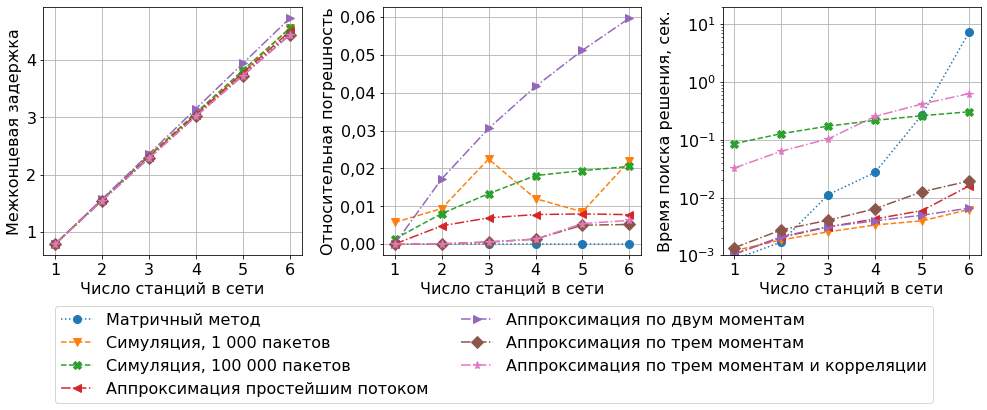

In [56]:
plot_data(BASIC_DATA, BASIC_INP['max_net_size'], file_name='olga_mm1n.pdf')

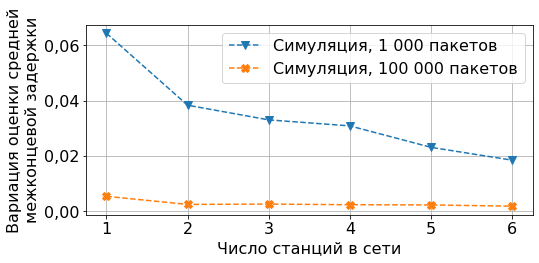

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax.plot(OX, [item[1] for item in BASIC_DATA['sim_rough']], **BASIC_STYLES['sim_rough'])
ax.plot(OX, [item[1] for item in BASIC_DATA['sim_fine']], **BASIC_STYLES['sim_fine'])
ax.grid()
ax.set_xlabel('Число станций в сети')
ax.set_ylabel('Вариация оценки средней\nмежконцевой задержки')
ax.legend()

На графиках показаны зависимости межконцевых задержек от числа станций в сети, время, затраченное на писк решения, а также вариация численных оценок, полученных на разных итерациях. Можно видеть, что точность оценки средней межконцевой задержки оказывается достаточно высокой даже при моделировании всего 1000 пакетов, однако вариация оценки оказывается высокой (до 6%), то есть при однократном выполнении симуляции оценка может достаточно сильно отклоняться. При моделировании 50'000 пакетов вариация мала. 

Время вычисления с помощью матричного метода растет экспоненциально, как и размерность выходящих потоков. Для систем малого размера вычисление матричным методом оказывается быстрее симуляции, однако уже для сетей с $N = 5$ станциями симуляция работает быстрее. Время, требуемое для выполнения симуляции, пропорционально числу моделируемых пакетов, и зависит почти линейно от числа станций в сети. Таким образом, для получения численных оценок характеристик сети большой размерности симуляция оказывается единственным практически применимым методом.

## Расчет характеристик системы с произвольными распределениями

Пакет `pyqumo` позволяет вычислять оценки сетей массового обслуживания с входящими MAP-потоками и PH-распределениями с помощью матричного метода и имитационного моделирования. В качестве более общего примера рассмотрим сеть, в которой входящий $\text{MAP}(D_0, D_1)$:

$$
D_0 = \begin{pmatrix}
-1 & 0.4 & 0\\
1 & -1 & 0\\
0,2 & 0 & -200
\end{pmatrix}\qquad
D_1 = \begin{pmatrix}
0,58 & 0 & 0,02\\
0 & 0 & 0\\
0 & 0 & 199.8
\end{pmatrix},
$$

а в качестве PH-распределения $\text{PH}(S, \vec{p})$ используется гиперэрланговское распредеделение:

$$
S = \begin{pmatrix}
-100 &  100 &   0   &  0    &    0  &   0   \\
  0  & -100 &  100  &  0    &    0  &   0   \\
  0  &   0  & -100  &  0    &    0  &   0   \\
  0  &   0  &   0   & -10^5 &  10^5 &   0   \\
  0  &   0  &   0   &  0    & -10^5 &  10^5 \\
  0  &   0  &   0   &  0    &    0  & -10^5
\end{pmatrix}\qquad
\vec{p}^T = \begin{pmatrix}
0,9 \\
0   \\
0   \\
0,1 \\
0   \\
0
\end{pmatrix}
$$.

Емкость очереди будем полагать равной $K = 2$. 

Рассматриваемый MAP-поток имеет среднюю интенсивность $\lambda \approx 13,72$, коэффициент вариации $c_a \approx 8,13$ и коэффициент корреляции (с лагом 1) $\rho_1 \approx 0,422$. Интенсивность обслуживания $\mu \approx 37,033$, коэффициент вариации длительности обслуживания $c_s \approx 0,694$.

Размерность выходящего потока с первого узла моделируемой сети равна $72 = 3 \bullet 6 \bullet (2 + 2)$. Выходящий поток со второго узла уже будет иметь $1728$ состояний, а с третьего - $41'472$ состояний. Из-за столь быстрого роста размерности задачи ограничим применение матричного метода сетью длины $N = 2$. С помощью симуляции найдем оценки межконцевых задержек для сетей большего размера, вплоть до $N_{max} = 10$.

In [25]:
S = np.asarray([
    [-100, 100, 0, 0, 0, 0],
    [0, -100, 100, 0, 0, 0],
    [0, 0, -100, 0, 0, 0],
    [0, 0, 0, -100_000, 100_000, 0],
    [0, 0, 0, 0, -100_000, 100_000],
    [0, 0, 0, 0, 0, -100_000]
])
p = np.asarray([0.9, 0, 0, 0.1, 0, 0])

PH = PhaseType(S, p)
print(f"Mean: {PH.mean:.3f}\n"
      f"Std : {PH.std:.3f}\n"
      f"CV  : {PH.cv:.3f}\n"
      f"Rate: {PH.rate:.3f}")
print("S:")
print_matrix(S)
print("tau:")
print_matrix(p.reshape((1, len(p))))

Mean: 0.027
Std : 0.019
CV  : 0.694
Rate: 37.033
S:


<IPython.core.display.Math object>

tau:


<IPython.core.display.Math object>

In [26]:
D0 = np.asarray([
    [-1, 0.4, 0],
    [1, -1, 0],
    [0.2, 0, -200]
])
D1 = np.asarray([
    [0.58, 0, 0.02],
    [0, 0, 0],
    [0, 0, 199.8]
])

MAP = MarkovArrival(D0, D1)
print(f"Mean: {MAP.mean:.3f}\n"
      f"Std : {MAP.std:.3f}\n"
      f"CV  : {MAP.cv:.3f}\n"
      f"Rate: {MAP.rate:.3f}\n"
      f"Corr: {MAP.lag(1)}")

print("D0:")
print_matrix(D0)

print("D1:")
print_matrix(D1)

Mean: 0.073
Std : 0.593
CV  : 8.130
Rate: 13.720
Corr: 0.42208306174254717
D0:


<IPython.core.display.Math object>

D1:


<IPython.core.display.Math object>

In [27]:
CAPACITY = 2

In [51]:
def compute_analytic_delay(arrival, service, capacity, net_size):
    t0 = time.time()
    ret = mapph1n_tandem.solve_iterative(MAP, PH, capacity, net_size, max_precise_order=100000)
    elapsed = time.time() - t0
    return ret.delay, elapsed

def compute_simulation_delay(arrival, service, capacity, net_size, max_packets=50_000):
    t0 = time.time()
    sim_ret = simulate_tandem(arrival, [service.copy() for _ in range(net_size)], capacity, max_packets)
    elapsed = time.time() - t0
    return sim_ret.delivery_delays[0].avg, elapsed

In [52]:
MAX_ANA_NET_SIZE = 2
ANA_COMPLEX_DELAYS, ANA_COMPLEX_ELAPSED = [], []

for n in range(1, MAX_ANA_NET_SIZE+1):
    d, e = compute_analytic_delay(MAP, PH, CAPACITY, n)
    ANA_COMPLEX_DELAYS.append(d)
    ANA_COMPLEX_ELAPSED.append(e)

print(ANA_COMPLEX_DELAYS)
print(ANA_COMPLEX_ELAPSED)

[0.06866484045420225, 0.11594086850479109]
[0.016666412353515625, 1.9080116748809814]


In [56]:
MAX_SIM_NET_SIZE = 10
MAX_SIM_PACKETS = 50_000
MAX_SIM_ITERS = 10
SIM_COMPLEX_DELAYS, SIM_COMPLEX_ELAPSED = [], []

for n in range(1, MAX_SIM_NET_SIZE+1):
    for _ in range(MAX_SIM_ITERS):
        delays, elapsed = [], []
        d, e = compute_simulation_delay(MAP, PH, CAPACITY, n, MAX_SIM_PACKETS)
        delays.append(d)
        elapsed.append(e)
    
    SIM_COMPLEX_DELAYS.append(np.mean(delays))
    SIM_COMPLEX_ELAPSED.append(np.mean(elapsed))

print(SIM_COMPLEX_DELAYS)
print(SIM_COMPLEX_ELAPSED)

[0.07042246397904364, 0.11771721944652176, 0.16277678448052377, 0.20329769593642125, 0.23953098370637643, 0.28813612477994954, 0.32838552271141, 0.3588455809083046, 0.4005654268152447, 0.43859327065135567]
[0.024000167846679688, 0.03099966049194336, 0.037001848220825195, 0.044997453689575195, 0.05000114440917969, 0.05499744415283203, 0.06000018119812012, 0.06700825691223145, 0.07397055625915527, 0.07699918746948242]


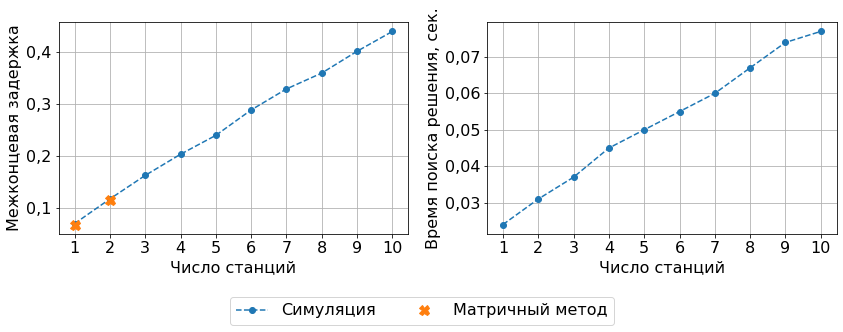

In [70]:
OX = np.arange(1, MAX_SIM_NET_SIZE + 1)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

SIM_STYLE      = {'linestyle': '--', 'marker': 'o', 'markersize': 6, 'label': f'Симуляция'}
ANA_STYLE      = {'linestyle': '', 'marker': 'X', 'markersize': 10, 'label': f'Матричный метод'}

ax0.plot(OX, SIM_COMPLEX_DELAYS, **SIM_STYLE)
ax0.plot(np.arange(1, MAX_ANA_NET_SIZE+1), ANA_COMPLEX_DELAYS, **ANA_STYLE)
ax0.set_ylabel("Межконцевая задержка")

ax1.plot(OX, SIM_COMPLEX_ELAPSED, **SIM_STYLE)
# ax1.plot(np.arange(1, MAX_ANA_NET_SIZE+1), ANA_COMPLEX_ELAPSED, **ANA_STYLE)
ax1.set_ylabel('Время поиска решения, сек.')

for ax in (ax0, ax1):
    ax.grid()
    ax.set_xticks(OX)
    ax.set_xlabel("Число станций")

plt.tight_layout()
fig.legend(*ax0.get_legend_handles_labels(), 
           loc='lower center', bbox_to_anchor=(0.5, -0.14), ncol=3)

fig.savefig(os.path.join("images", "olga_mapph1n.pdf"), bbox_inches="tight")

На графике показана зависимость межконцевой задержки от числа станций, а также время, которое требовалось на выполнение симуляции. При каждом выполнении симуляции моделировалось по $50'000$ пакетов. Для сетей длины $N = 1, 2$ решение также было найдено матричным методом. Как показано на графике, оценки, полученные матричным методом и с помощью симуляции практически идентичны. 

Отметим, что на выполнение расчета матричным методом для сети длины $N = 1$ потребовалось $0,11$ сек., а для сети длины $N = 2$ потребовалось $1,9$ сек. Попытка получить оценки для сети длины $N = 3$ привели к переполнению оперативной памяти.